In [62]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.tensorboard import SummaryWriter
import time
from datetime import datetime

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [2]:
df = sns.load_dataset("titanic")

In [3]:
## Randomly select a fraction of the dataset
FRACTION = 0.8

train_df = df.sample(frac=FRACTION, random_state=42) # fix seed for reproducibility
# Get the remaining 20% of rows for the test set
# This is achieved by selecting rows whose index is not present in the training set
test_df = df.drop(train_df.index)
# Display the shapes of the resulting DataFrames
print(f"Shape of training DataFrame: {train_df.shape}")
print(f"Shape of test DataFrame: {test_df.shape}")

# You can now save these DataFrames if needed
train_df.to_csv('train_data.csv', index=False)
test_df.to_csv('test_data.csv', index=False)

Shape of training DataFrame: (713, 15)
Shape of test DataFrame: (178, 15)


In [4]:
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [5]:
df.isnull().sum()

survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64

In [6]:
(df.isnull().sum() / len(df)) * 100

survived        0.000000
pclass          0.000000
sex             0.000000
age            19.865320
sibsp           0.000000
parch           0.000000
fare            0.000000
embarked        0.224467
class           0.000000
who             0.000000
adult_male      0.000000
deck           77.216611
embark_town     0.224467
alive           0.000000
alone           0.000000
dtype: float64

In [7]:
# Get the data types of all columns
column_dtypes = df.dtypes
print(column_dtypes)

survived          int64
pclass            int64
sex              object
age             float64
sibsp             int64
parch             int64
fare            float64
embarked         object
class          category
who              object
adult_male         bool
deck           category
embark_town      object
alive            object
alone              bool
dtype: object


In [8]:
# sns.heatmap(df.isnull(), cbar=False, yticklabels=False)
# plt.title("Missing Data Heatmap")
# plt.show()

In [9]:
## Drop columns with missing value and alive column
df_nomissing = df.drop(columns=['age', 'deck', 'embarked', 'embark_town', 'survived',])

In [10]:
df_nomissing.head()

,pclass,sex,sibsp,parch,fare,class,who,adult_male,alive,alone
0,3,male,1,0,7.2500,Third,man,True,no,False
1,1,female,1,0,71.2833,First,woman,False,yes,False
2,3,female,0,0,7.9250,Third,woman,False,yes,True
3,1,female,1,0,53.1000,First,woman,False,yes,False
4,3,male,0,0,8.0500,Third,man,True,no,True


In [11]:
# Normalize numeric feature
from sklearn.preprocessing import StandardScaler
num_cols = ["fare", "sibsp", "parch"]
scaler = StandardScaler()
df_nomissing[num_cols] = scaler.fit_transform(df_nomissing[num_cols])

In [12]:
#Convert categorial features to integers using Label Encoding
from sklearn.preprocessing import LabelEncoder

cat_cols = ["pclass", "sex", "class", "who", "adult_male", "alive", "alone"]  # treat pclass as categorical
label_encoders = {}

for col in cat_cols:
    le = LabelEncoder()
    df_nomissing[col] = le.fit_transform(df_nomissing[col])
    label_encoders[col] = le

In [13]:
df_nomissing

,pclass,sex,sibsp,parch,fare,class,who,adult_male,alive,alone
0,2,1,0.432793,-0.473674,-0.502445,2,1,1,0,0
1,0,0,0.432793,-0.473674,0.786845,0,2,0,1,0
2,2,0,-0.474545,-0.473674,-0.488854,2,2,0,1,1
3,0,0,0.432793,-0.473674,0.420730,0,2,0,1,0
4,2,1,-0.474545,-0.473674,-0.486337,2,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...
886,1,1,-0.474545,-0.473674,-0.386671,1,1,1,0,1
887,0,0,-0.474545,-0.473674,-0.044381,0,2,0,1,1
888,2,0,0.432793,2.008933,-0.176263,2,2,0,0,0
889,0,1,-0.474545,-0.473674,-0.044381,0,1,1,1,1


In [14]:
## Randomly select a fraction of the dataset
FRACTION = 0.8

train_df_nomissing = df_nomissing.sample(frac=FRACTION, random_state=42) # fix seed for reproducibility
# Get the remaining 20% of rows for the test set
# This is achieved by selecting rows whose index is not present in the training set
test_df_nomissing = df_nomissing.drop(train_df_nomissing.index)
# Display the shapes of the resulting DataFrames
print(f"Shape of training DataFrame: {train_df_nomissing.shape}")
print(f"Shape of test DataFrame: {test_df_nomissing.shape}")

# You can now save these DataFrames if needed
train_df_nomissing.to_csv('train_data_nomissing_std.csv', index=False)
test_df_nomissing.to_csv('test_data_nomissing_std.csv', index=False)

Shape of training DataFrame: (713, 10)
Shape of test DataFrame: (178, 10)


In [15]:
X_train = train_df_nomissing.values.astype("float32")
X_test = test_df_nomissing.values.astype("float32")

# PyTorch Dataset for loading data to training loop

In [49]:
from torch.utils.data import Dataset, DataLoader

class TitanicAutoencoderDataset(Dataset):
    def __init__(self, X):
        self.X = torch.tensor(X, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.X[idx]  # input = target

train_ds = TitanicAutoencoderDataset(X_train)
test_ds = TitanicAutoencoderDataset(X_test)

# train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
# test_loader = DataLoader(test_ds, batch_size=64)


# Autoencoder model 

In [45]:
import torch.nn as nn

class TitanicAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim=4):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 16),
            nn.ReLU(),
            nn.Linear(16, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)       # compressed embedding
        x_recon = self.decoder(z) # reconstructed input
        return x_recon

    def encode(self, x):
        return self.encoder(x)    # get embedding only


In [46]:
def plot_loss_curve(train_losses, test_losses):
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(train_losses, label="Train Loss", marker='o')
    ax.plot(test_losses, label="Test Loss", marker='x')
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.set_title("Train vs Test Loss")
    ax.legend()
    ax.grid(True)
    return fig

In [47]:
import subprocess

def get_gpu_utilization():
    result = subprocess.run(
        ['nvidia-smi', '--query-gpu=utilization.gpu,memory.used',
         '--format=csv,nounits,noheader'],
        stdout=subprocess.PIPE,
        text=True
    )
    gpu_util, mem_used = map(int, result.stdout.strip().split(','))
    return gpu_util, mem_used

# Training loop

In [ ]:
model = TitanicAutoencoder(input_dim=X_train.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5) 
# This will halve the learning rate if avg_test_loss doesn't improve for 5 epochs.

loss_fn = nn.MSELoss()

# Create a timestamped run directory
RUN_NAME = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
LOG_DIR = f"runs/autoencoder_{RUN_NAME}"
BATCH_SIZE = 256
WORKERS = 2

writer = SummaryWriter(log_dir=LOG_DIR)

#Training loop
# Prepare training and test datasets
train_ds = TitanicAutoencoderDataset(X_train)
test_ds = TitanicAutoencoderDataset(X_test)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, num_workers=WORKERS, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, num_workers=WORKERS)

# Track losses
train_losses = []
test_losses = []

# Training loop
num_epochs = 500
for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    train_loss = 0.0

    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)

        recon = model(x)
        loss = loss_fn(recon, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    end_time = time.time()
    epoch_duration = end_time - start_time
    # GPU metrics
    gpu_alloc = torch.cuda.memory_allocated() / 1024**2
    gpu_reserved = torch.cuda.memory_reserved() / 1024**2
    writer.add_scalar("GPU/Memory_Allocated_MB", gpu_alloc, epoch)
    writer.add_scalar("GPU/Memory_Reserved_MB", gpu_reserved, epoch)

    try:
        gpu_util, mem_used = get_gpu_utilization()
        writer.add_scalar("GPU/Utilization_%", gpu_util, epoch)
        writer.add_scalar("GPU/Memory_Used_MB", mem_used, epoch)
    except:
        pass  # In case nvidia-smi isn't available

    # Evaluate on test set
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            y = y.to(device)
            recon = model(x)
            loss = loss_fn(recon, y)
            test_loss += loss.item()

    avg_test_loss = test_loss / len(test_loader)
    test_losses.append(avg_test_loss)

    # ✅ Log scalar losses
    writer.add_scalar("Loss/train", avg_train_loss, epoch)
    writer.add_scalar("Loss/test", avg_test_loss, epoch)
    writer.add_figure("Loss Overlap Curve", plot_loss_curve(train_losses, test_losses), global_step=epoch)

    # ✅ Log weights and gradients
    for name, param in model.named_parameters():
        writer.add_histogram(f"Weights/{name}", param, epoch)
        if param.grad is not None:
            writer.add_histogram(f"Gradients/{name}", param.grad, epoch)

    # ✅ Log activation from encoder
    with torch.no_grad():
        activation_sample = torch.tensor(X_train[:1], dtype=torch.float32).to(device)
        encoded = model.encoder(activation_sample)
        writer.add_histogram("Activations/EncoderOutput", encoded, epoch)
        current_lr = optimizer.param_groups[0]['lr']
        writer.add_scalar("LR", current_lr, epoch)

    print(f"Epoch {epoch+1:2d} | Train Loss: {avg_train_loss:.4f} | Test Loss: {avg_test_loss:.4f} | LR: {current_lr:.6f} | Time: {epoch_duration:.2f} sec")
    scheduler.step(avg_test_loss)

# ✅ After training — log embeddings to projector
with torch.no_grad():
    sample_input = torch.tensor(X_test[:500], dtype=torch.float32).to(device)
    latent_vectors = model.encoder(sample_input)
    metadata = [f"Passenger {i}" for i in range(sample_input.shape[0])]
    writer.add_embedding(latent_vectors, metadata=metadata, tag="LatentEmbeddings", global_step=num_epochs)
    
writer.close()

Epoch  1 | Train Loss: 1.1483 | Test Loss: 1.0659 | LR: 0.001000 | Time: 0.23 sec
Epoch  2 | Train Loss: 1.1360 | Test Loss: 1.0504 | LR: 0.001000 | Time: 0.23 sec
Epoch  3 | Train Loss: 1.1164 | Test Loss: 1.0353 | LR: 0.001000 | Time: 0.25 sec
Epoch  4 | Train Loss: 1.0980 | Test Loss: 1.0204 | LR: 0.001000 | Time: 0.24 sec
Epoch  5 | Train Loss: 1.0812 | Test Loss: 1.0050 | LR: 0.001000 | Time: 0.24 sec
Epoch  6 | Train Loss: 1.0641 | Test Loss: 0.9889 | LR: 0.001000 | Time: 0.26 sec
Epoch  7 | Train Loss: 1.0483 | Test Loss: 0.9721 | LR: 0.001000 | Time: 0.24 sec
Epoch  8 | Train Loss: 1.0320 | Test Loss: 0.9544 | LR: 0.001000 | Time: 0.24 sec
Epoch  9 | Train Loss: 1.0170 | Test Loss: 0.9359 | LR: 0.001000 | Time: 0.24 sec
Epoch 10 | Train Loss: 0.9947 | Test Loss: 0.9164 | LR: 0.001000 | Time: 0.25 sec
Epoch 11 | Train Loss: 0.9750 | Test Loss: 0.8959 | LR: 0.001000 | Time: 0.24 sec
Epoch 12 | Train Loss: 0.9469 | Test Loss: 0.8737 | LR: 0.001000 | Time: 0.23 sec
Epoch 13 | Train

## Run Tensorboard to inspect results

To run Tensorboard, you may run it from the same directory as this notebook. You may run the following command either during or after the training run:

```
tensorboard --logdir=runs
```

Make sure you activated the appropriate virtual environment which has tensorboard installed.

You should see the following:

```
Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.20.0 at http://localhost:6006/ (Press CTRL+C to quit)
```

and you may use a browser to access tensorboard via the URL above.

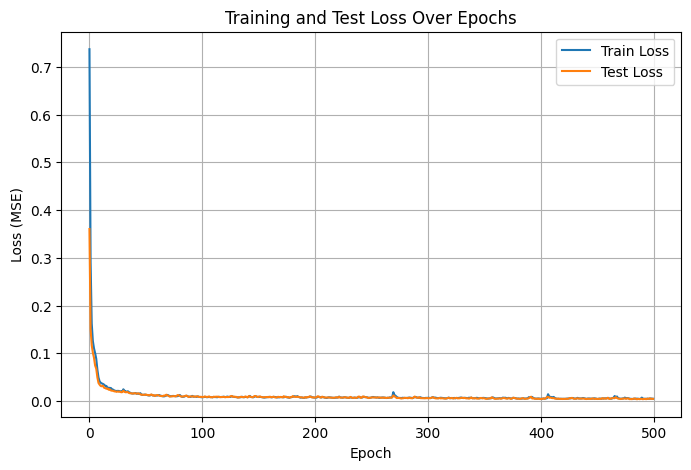

In [30]:
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Training and Test Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

In [31]:
plt.savefig("loss_curve.png", dpi=300)

<Figure size 640x480 with 0 Axes>

# Get embedding vector from encoder side of the model

In [34]:
with torch.no_grad():
    x_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    embeddings = model.encoder(x_tensor)  # Shape: [n_samples, latent_dim]


In [36]:
embeddings.shape

torch.Size([178, 4])

In [37]:
embedding_df = pd.DataFrame(embeddings.cpu().numpy(), columns=[f"embeddings{i}" for i in range(embeddings.shape[1])])
embedding_df.to_csv("titanic_latent_embeddings.csv", index=False)